In [1]:
import os
import argparse
import requests
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    plot_confusion_matrix, 
    plot_roc_curve, 
)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST, CIFAR10, CIFAR100, EMNIST

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") 

import timm

In [2]:
model = timm.create_model("resnet18", pretrained=False)

In [3]:
train_transform = T.Compose([T.ToTensor(), T.RandomHorizontalFlip(0.5), T.RandomErasing()])
test_transform = T.Compose([T.ToTensor()])

train_set = CIFAR10(root="/opt/datasets/cifar10", train=True,  transform=train_transform, download=True)
test_set  = CIFAR10(root="/opt/datasets/cifar10", train=False, transform=test_transform, download=True)

labeled_set   = Subset(train_set, list(range(0, len(train_set)//5)))
unlabeled_set = Subset(train_set, list(range(len(train_set)//5, len(train_set))))

train_loader     = DataLoader(train_set,     batch_size=256, shuffle=True,  pin_memory=True, num_workers=1)
labeled_loader   = DataLoader(labeled_set,   batch_size=256, shuffle=True,  pin_memory=True, num_workers=1)
unlabeled_loader = DataLoader(unlabeled_set, batch_size=256, shuffle=True,  pin_memory=True, num_workers=1)
test_loader      = DataLoader(test_set,      batch_size=256, shuffle=False, pin_memory=True, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(50):
    for X, y in labeled_loader:
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)

        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

In [5]:
all_targets = []
all_preds   = []

model.eval()
with torch.no_grad():
    for X, y in labeled_loader:
        X = X.to(device)
        out = model(X)
        val, ids = torch.max(out, dim=1)

        all_targets.extend(y.tolist())
        all_preds.extend(ids.detach().cpu().tolist())

acc = accuracy_score(np.asarray(all_targets), np.asarray(all_preds))
print("labeled_acc:", acc)

all_targets = []
all_preds   = []

model.eval()
with torch.no_grad():
    for X, y in unlabeled_loader:
        X = X.to(device)
        out = model(X)
        val, ids = torch.max(out, dim=1)

        all_targets.extend(y.tolist())
        all_preds.extend(ids.detach().cpu().tolist())

acc = accuracy_score(np.asarray(all_targets), np.asarray(all_preds))
print("unlabeled_acc:", acc)

model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        out = model(X)
        val, ids = torch.max(out, dim=1)

        all_targets.extend(y.tolist())
        all_preds.extend(ids.detach().cpu().tolist())

acc = accuracy_score(np.asarray(all_targets), np.asarray(all_preds))
print("test_acc:", acc)

labeled_acc: 0.8614
unlabeled_acc: 0.600025
test_acc: 0.607


In [6]:
optimizer.state_dict()["state"][0].keys()

dict_keys(['step', 'exp_avg', 'exp_avg_sq'])

In [7]:
test_loader  = DataLoader(test_set, batch_size=1, shuffle=False)

param_keys = optimizer.state_dict()["param_groups"][0]["params"]
grad_scores = []
weighted_scores = []
pseudo_labels = []
highest_probs = []
entropies = []

epsilon = torch.tensor([1e-9]).to(device)

for X, y in test_loader:

    optimizer.zero_grad()
    X = X.to(device)
    out = model(X)
    out = torch.softmax(out, dim=1)
    entropy = torch.sum(out * torch.log(out))
    prob, y_pred = torch.max(out, dim=1) # pseudo-label
    
    pseudo_labels.append(y_pred.item())
    highest_probs.append(prob.item())
    entropies.append(entropy.item())

    # TODO: expected gradient calculation
    loss = criterion(out, y_pred.detach())
    loss.backward()

    grads = []
    weighted_grads = []
    
    # Grad calculation
    with torch.no_grad():
        for (name, param), key in zip(model.named_parameters(), param_keys):
            _grad = param.grad.clone().detach()
            _weighted_grad = _grad / torch.sqrt(optimizer.state_dict()["state"][key]["exp_avg_sq"] + epsilon)

            grads.append(_grad.flatten())
            weighted_grads.append(_weighted_grad.flatten())

        grads = torch.cat(grads)
        weighted_grads = torch.cat(weighted_grads)

        grad_norm = torch.norm(grads)
        weighted_norm = torch.norm(weighted_grads)

    grad_scores.append(grad_norm.item())
    weighted_scores.append(weighted_norm.item())


In [8]:
grad_scores = np.asarray(grad_scores)
weighted_scores = np.asarray(weighted_scores)

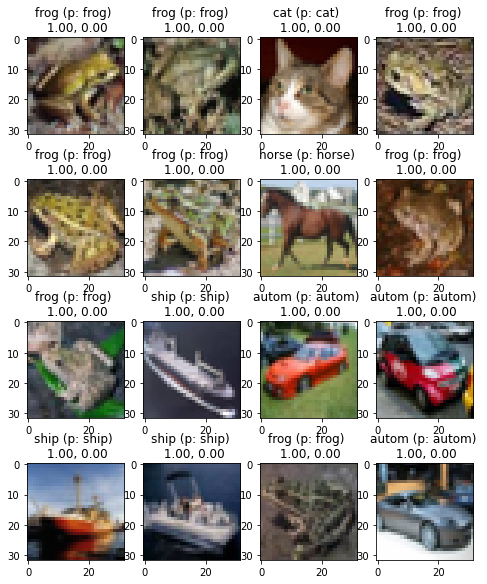

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(8, 10))
grad_ids = grad_scores.argsort()

for i in range(4):
    for j in range(4):
        idx = grad_ids[i * 4 + j]
        axes[i][j].imshow(test_set[idx][0].permute(1, 2, 0))
        axes[i][j].set_title(f"{test_set.classes[test_set[idx][1]][:5]} (p: {test_set.classes[pseudo_labels[idx]][:5]}) \n {highest_probs[idx]:.2f}, {-entropies[idx]:.2f}")

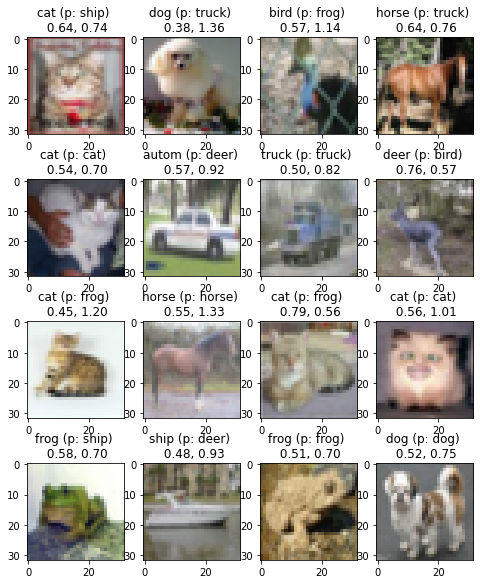

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(8, 10))
grad_ids = grad_scores.argsort()[::-1]

for i in range(4):
    for j in range(4):
        idx = grad_ids[i * 4 + j]
        axes[i][j].imshow(test_set[idx][0].permute(1, 2, 0))
        axes[i][j].set_title(f"{test_set.classes[test_set[idx][1]][:5]} (p: {test_set.classes[pseudo_labels[idx]][:5]}) \n {highest_probs[idx]:.2f}, {-entropies[idx]:.2f}")

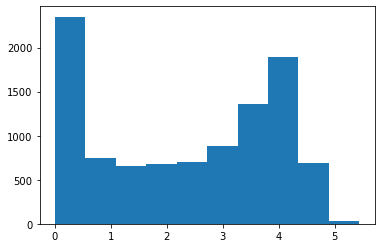

In [11]:
plt.hist(np.log1p(grad_scores))
plt.show()

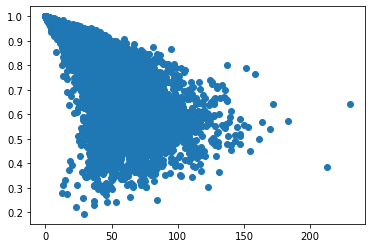

In [12]:
plt.scatter(grad_scores, highest_probs)

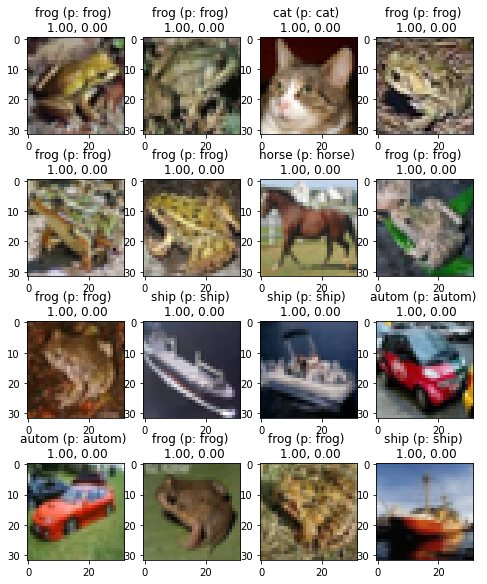

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(8, 10))
grad_ids = weighted_scores.argsort()

for i in range(4):
    for j in range(4):
        idx = grad_ids[i * 4 + j]
        axes[i][j].imshow(test_set[idx][0].permute(1, 2, 0))
        axes[i][j].set_title(f"{test_set.classes[test_set[idx][1]][:5]} (p: {test_set.classes[pseudo_labels[idx]][:5]}) \n {highest_probs[idx]:.2f}, {-entropies[idx]:.2f}")

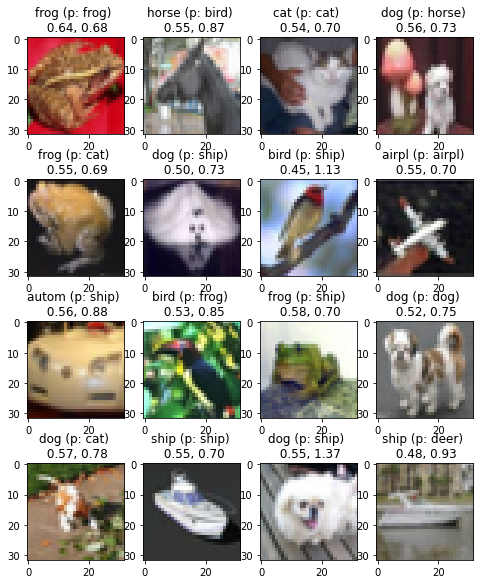

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(8, 10))
grad_ids = weighted_scores.argsort()[::-1]

for i in range(4):
    for j in range(4):
        idx = grad_ids[i * 4 + j]
        axes[i][j].imshow(test_set[idx][0].permute(1, 2, 0))
        axes[i][j].set_title(f"{test_set.classes[test_set[idx][1]][:5]} (p: {test_set.classes[pseudo_labels[idx]][:5]}) \n {highest_probs[idx]:.2f}, {-entropies[idx]:.2f}")

Text(0, 0.5, 'predicted probability')

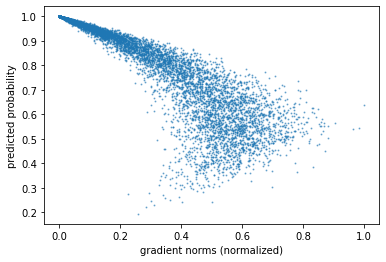

In [25]:
# plt.scatter(grad_scores/max(grad_scores), highest_probs, s=1, alpha=0.5)
plt.scatter(weighted_scores/max(weighted_scores), highest_probs, s=1, alpha=0.5)
plt.xlabel("gradient norms (normalized)")
plt.ylabel("predicted probability")

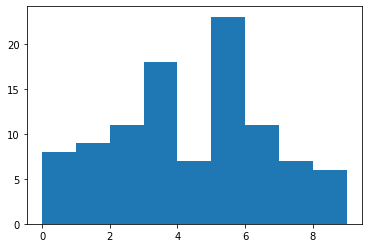

In [26]:
targets = np.asarray(test_set.targets)
targets = targets[grad_ids[:100]]
plt.hist(targets, bins=np.arange(10))
plt.show()

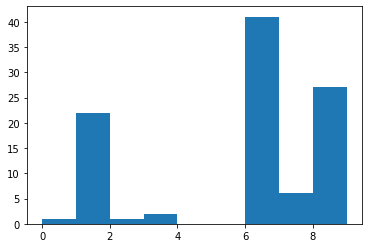

In [27]:
targets = np.asarray(test_set.targets)
targets = targets[grad_ids[-100:]]
plt.hist(targets, bins=np.arange(10))
plt.show()

In [18]:
targets = np.asarray(test_set.targets)
np.unique(targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

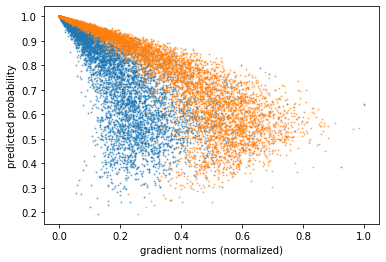

In [28]:
plt.scatter(grad_scores/max(grad_scores), highest_probs, s=1, alpha=0.5)
plt.scatter(weighted_scores/max(weighted_scores), highest_probs, s=1, alpha=0.5)
plt.xlabel("gradient norms (normalized)")
plt.ylabel("predicted probability")
plt.show()

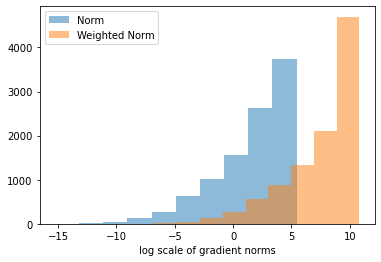

In [29]:
plt.hist(np.log(grad_scores), alpha=0.5, label="Norm")
plt.hist(np.log(weighted_scores), alpha=0.5, label="Weighted Norm")
plt.xlabel("log scale of gradient norms")
plt.legend()
plt.show()

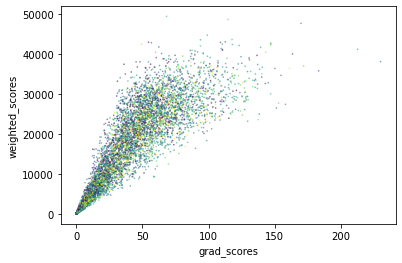

In [30]:
plt.scatter(grad_scores, weighted_scores, s=0.5, c=test_set.targets, alpha=0.5)
plt.xlabel("grad_scores")
plt.ylabel("weighted_scores")
plt.show()

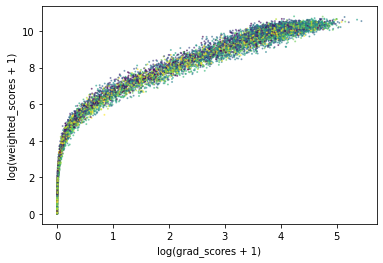

In [22]:
plt.scatter(np.log1p(grad_scores), np.log1p(weighted_scores), s=1, c=test_set.targets, alpha=0.5)
plt.xlabel("log(grad_scores + 1)")
plt.ylabel("log(weighted_scores + 1)")
plt.show()

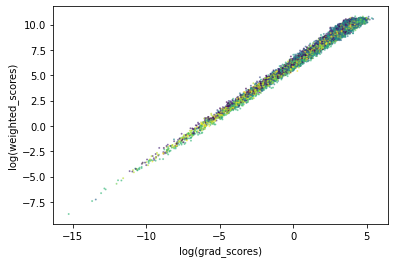

In [23]:
plt.scatter(np.log(grad_scores), np.log(weighted_scores), s=1, c=test_set.targets, alpha=0.5)
plt.xlabel("log(grad_scores)")
plt.ylabel("log(weighted_scores)")
plt.show()

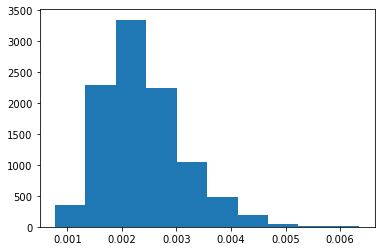

In [52]:
plt.hist(grad_scores/weighted_scores)
# plt.xlabel("log(grad_scores)")
# plt.ylabel("log(weighted_scores)")
plt.show()

In [40]:
cnt, intervals = np.histogram(grad_scores)

In [38]:
targets = np.asarray(test_set.targets)
corrects = []
for target, p_lab, score in zip(targets, pseudo_labels, grad_scores):
    corrects.append(1 if p_lab == target else 0)
print(sum(corrects)/len(corrects))

0.6349


In [42]:
df = pd.DataFrame({"score": grad_scores, "correct": corrects})
df.head()

,score,correct
0,3.095101,1
1,56.476772,1
2,41.006363,1
3,39.041431,1
4,16.289570,0


Text(0, 0.5, '# correct samples (cumulative)')

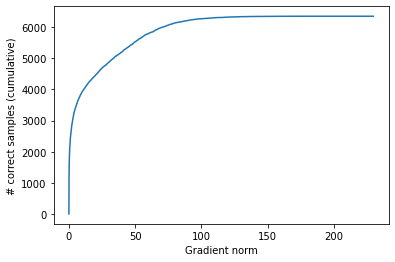

In [47]:
df = df.sort_values("score")
df["correct_rate"] = df["correct"].cumsum()
plt.plot(df["score"], df["correct_rate"])
plt.xlabel("Gradient norm")
plt.ylabel("# correct samples (cumulative)")

In [48]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']